In [7]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
pd.options.mode.chained_assignment = None

In [8]:
AMS_DATA_DIR = Path("../../eptnr_package/eptnr/datasets/amsterdam_10_2022")

In [9]:
# Load Amsterdam's neighborhoods with population-weighted centroids
ams_neighborhoods = gpd.read_file(AMS_DATA_DIR.joinpath('ams_neighbourhoods_2022.geojson'))

In [10]:
ams_neighborhoods['centroid'] = gpd.points_from_xy(ams_neighborhoods.cent_x, ams_neighborhoods.cent_y, crs='EPSG:4326')
ams_neighborhoods['res_centroid'] = gpd.points_from_xy(ams_neighborhoods.res_cent_x, ams_neighborhoods.res_cent_y, crs='EPSG:4326')
# Places without residential buildings have no residential centroids. Find them and assign to them the geographical centroid.
ams_neighborhoods.loc[ams_neighborhoods['res_cent_x'].isna(), 'res_centroid'] = ams_neighborhoods[ams_neighborhoods['res_cent_x'].isna()]['centroid']
ams_neighborhoods = ams_neighborhoods.drop(columns=['res_cent_x', 'res_cent_y', 'cent_x', 'cent_y'])

<AxesSubplot: >

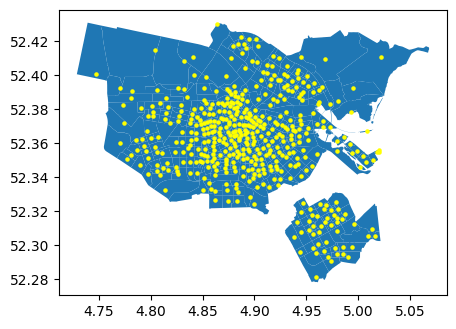

In [11]:
base = ams_neighborhoods.plot(figsize=(5,5))
ams_neighborhoods.res_centroid.plot(ax=base, color='yellow', markersize = 5, figsize=(5,5))

In [13]:
# Load census data of The Netherlands
# You can find explanation of the fields here: https://tinyurl.com/y2z7he6b
kwb_21 = pd.read_excel(AMS_DATA_DIR.joinpath('cbs_netherlands_census_2021.xls'), na_values='.')
metadata_cols = ["gwb_code_10", "gwb_code_8", "regio", "gm_naam", "recs", "gwb_code"]

In [14]:
def kwb_to_float(kwb: pd.DataFrame) -> pd.DataFrame:
    comma_check = kwb.drop(columns=metadata_cols).apply(
        lambda x: x.str.contains(',').any() if x.dtype == object else False, axis=0)
    cs_floats = comma_check[comma_check == True]
    cs_float_cols = cs_floats.index.to_list()
    kwb[cs_float_cols] = kwb[cs_float_cols].apply(lambda x: x.str.replace(',', '.'), axis=0).astype(np.float64)
    return kwb

kwb_21 = kwb_to_float(kwb_21)

# Drop all Neighborhoods that have 0 inhabitants or 0 households
kwb_21 = kwb_21[kwb_21.a_inw!=0]
kwb_21 = kwb_21[kwb_21.a_hh!=0]

In [15]:
# Compute the number of inhabitants by adding the population with western and non-western migration backgrounds
kwb_21["n_inh"] = kwb_21["a_w_all"] + kwb_21["a_nw_all"]

In [16]:
def kwb_merge_ams_neighborhoods(kwb: pd.DataFrame, ams_neighborhoods: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    kwb['BU_CODE'] = kwb['gwb_code']
    kwb = kwb.drop(columns=metadata_cols)
    ams_neighborhoods = gpd.pd.merge(ams_neighborhoods, kwb, on='BU_CODE')
    return ams_neighborhoods

kwb_21_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_21, ams_neighborhoods)

In [19]:
kwb_21_ams_neighborhoods[kwb_21_ams_neighborhoods.BU_CODE=="BU03630000"]

BU_CODE      BU_NAAM                                           geometry  \
0  BU03630000  Kop Zeedijk  POLYGON ((4.90096 52.37724, 4.90195 52.37724, ...   

                   centroid              res_centroid  ind_wbi  a_inw  a_man  \
0  POINT (4.90026 52.37593)  POINT (4.90009 52.37552)      1.0   1110    645   

   a_vrouw  a_00_14  ...  g_afs_sc  g_3km_sc  a_opp_ha  a_lan_ha  a_wat_ha  \
0      465       45  ...       NaN       NaN         8         6         2   

   pst_mvp  pst_dekp  ste_mvs  ste_oad  n_inh  
0   1012.0       1.0      1.0   6776.0    600  

[1 rows x 119 columns]

In [21]:
kwb_21_ams_neighborhoods[['BU_CODE','BU_NAAM','geometry']].explore()

In [22]:
# Fill NaNs through spatial linear interpolation

def inverse_dist_weighted_average(weights, values):
    return sum([(1/weight) * value / sum(1/weights) for weight, value in zip(weights, values)])

kwb_ams_nhs = kwb_21_ams_neighborhoods

for col in tqdm(kwb_21_ams_neighborhoods.columns, position=1, leave=False):
    if kwb_ams_nhs[col].hasnans:
        entries = kwb_ams_nhs[kwb_ams_nhs[col].isna()]
        entries.res_centroid = entries.res_centroid.to_crs('epsg:32631')
        for i, entry in entries.iterrows():
            point = entry.res_centroid
            non_nan_areas = kwb_ams_nhs[~kwb_ams_nhs[col].isna()]
            distances = non_nan_areas.res_centroid.to_crs('epsg:32631').distance(point).sort_values()
            closest_distances_idxs = distances.index[:3]
            closest_distances = distances.loc[closest_distances_idxs].values
            closest_entries = non_nan_areas.loc[closest_distances_idxs]
            interpolated_nan_value = inverse_dist_weighted_average(closest_distances, closest_entries[col].values)
            kwb_ams_nhs.loc[entry.name, col] = interpolated_nan_value



 93%|█████████▎| 111/119 [08:33<00:49,  6.21s/it]
                                                 

In [26]:
def check_has_any_na(gdf: gpd.GeoDataFrame) -> bool:
    return gdf.apply(lambda x: x.isna(), axis=1).any(axis=0).any()

if not check_has_any_na(kwb_21_ams_neighborhoods):
    print("Saving files")

    # Storing the resulting data in the parquet format as others don't support multiple geometry fields
    kwb_21_ams_neighborhoods.to_parquet(AMS_DATA_DIR.joinpath('ams_census_and_neighborhood_data_2021.parquet'))
else:
    print("Some GeoDataFrames still have NaNs -> won't save them")

Saving files
